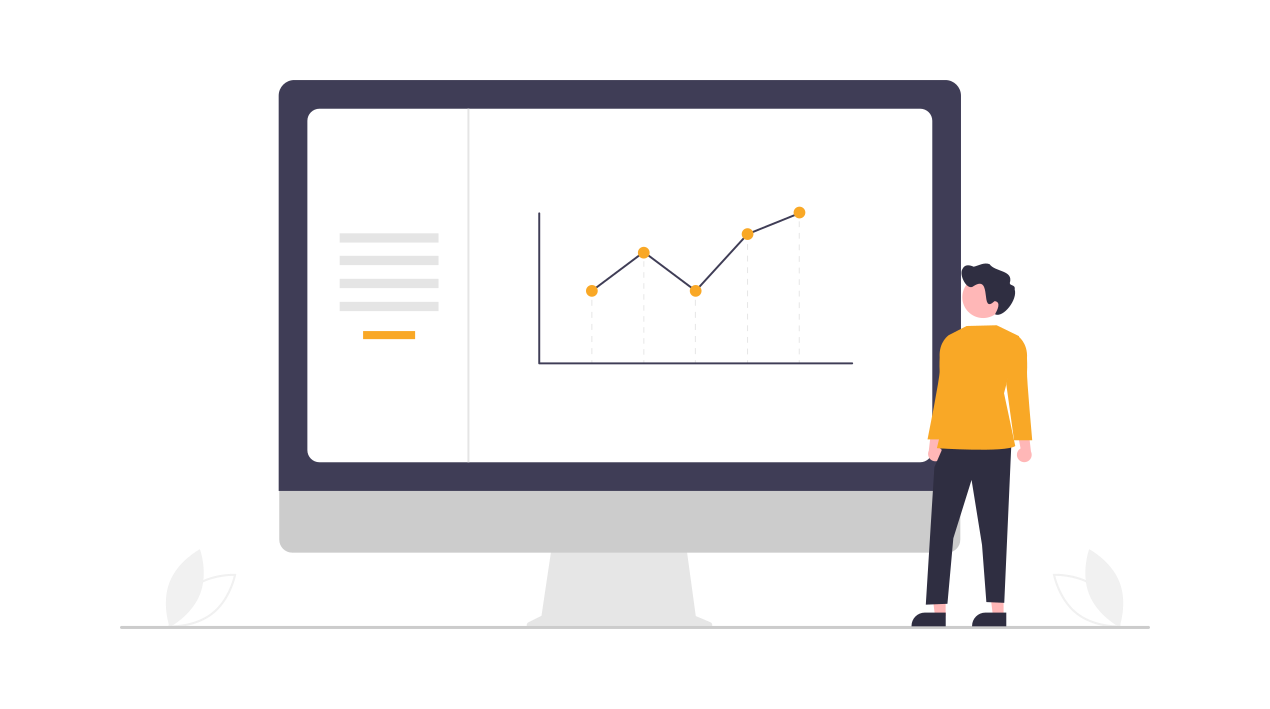

## Main Concept

[以前のnotebook](https://www.kaggle.com/code/tsunotsuno/updated-debertav3-lgbm-with-feature-engineering)で、DebertaとLGBMを組み合わせたモデルを試した。

しかし、このnotebookではautocorrectを使用しているが、このライブラリのライセンスはLGPLであり、コンペのルールを満たさない可能性が高い。([discussion](https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/discussion/433208))

また、[@cody11null](https://www.kaggle.com/cody11null)氏の[notebook](https://www.kaggle.com/code/cody11null/tuned-debertav3-lgbm-autocorrect)によると、さらにパラメータチューニングによって性能を向上をさせることができるようだ。

今回は、下記2点でDebertaのモデルを修正し、性能を向上させる。

- autocorrectを使用しない
- パラメータチューニング

In [my previous NOTEBOOK](https://www.kaggle.com/code/tsunotsuno/updated-debertav3-lgbm-with-feature-engineering), we tried a model that combines Deberta and LGBM.

However, this notebook uses autocorrect which license is LGPL, it seems that the notebook using this library may not meet this competition. ([discussion](https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/discussion/433208))

By the way, [@cody11null](https://www.kaggle.com/cody11null)'s [notebook](https://www.kaggle.com/code/cody11null/tuned-debertav3-lgbm- According to [autocorrect](), it seems that performance can be further improved by tuning parameters.

In this notebook, I will modify Deberta's model in the following two ways to improve performance.

- not autocorrect
- parameter tuning

### Feature Engineering

LGBMに使用する特徴量は以前と同じものを使用している。

I use the same features for LGBM as before.

[Using features]

- Text Length
- Length Ratio
- Word Overlap
- N-grams Co-occurrence
  - count
  - ratio
- Quotes Overlap
- Grammar Check
  - spelling: pyspellchecker

### Model Architecture

図のような構成のモデルを作成する。
今回はwordingとcontentを同時に学習する。

I use a model shown in the figure.
In this notebook, wording and content are learned together.

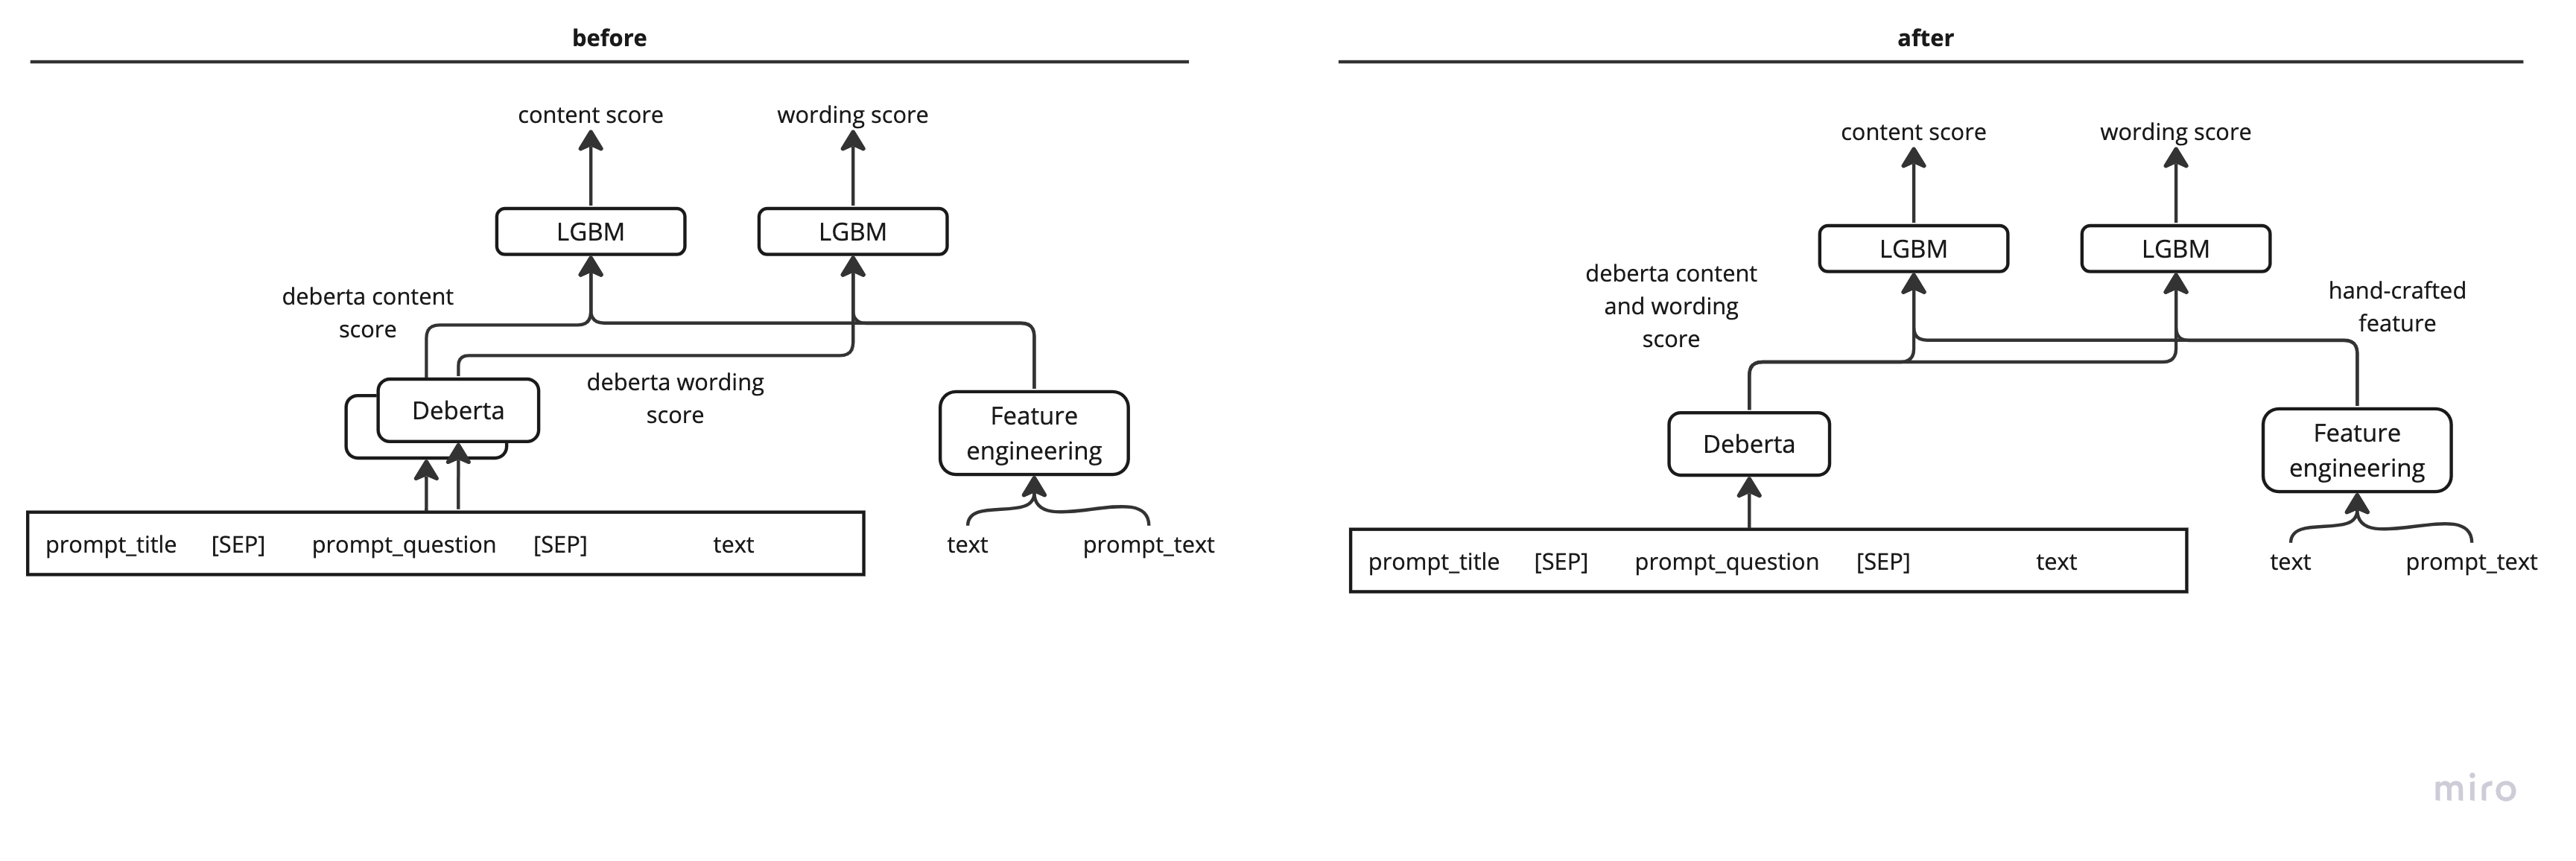

### Tuning

下記の変更を行う。

Make the following changes for tuning.

- content, wordingを同時に学習・推論
- fp16の使用
- epoch数を増加（5->10）
- hidden_dropout_prob(0.005 -> 0.007)
- attention_probs_dropout_prob(0.005 -> 0.007)
- auto_find_batch_sizeを使用

### References

- https://www.kaggle.com/code/cody11null/tuned-debertav3-lgbm-autocorrect
- https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/discussion/433208

### My previous notebooks

- https://www.kaggle.com/code/tsunotsuno/debertav3-baseline-content-and-wording-models
- https://www.kaggle.com/code/tsunotsuno/debertav3-w-prompt-title-question-fields
- https://www.kaggle.com/code/tsunotsuno/debertav3-with-llama2-example
- https://www.kaggle.com/code/tsunotsuno/debertav3-lgbm-with-feature-engineering
- https://www.kaggle.com/code/tsunotsuno/updated-debertav3-lgbm-with-spell-autocorrect
- https://www.kaggle.com/code/tsunotsuno/lgbm-debertav3-another-impl


In [1]:
!pip install "/kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl"

Processing /kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl


In [2]:
from typing import List
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import logging
import os
import gc
import shutil
import json
import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from datasets import Dataset,load_dataset, load_from_disk
from transformers import TrainingArguments, Trainer
from datasets import load_metric, disable_progress_bar
from sklearn.metrics import mean_squared_error
import torch
from sklearn.model_selection import KFold, GroupKFold
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from collections import Counter
import spacy
import re
from spellchecker import SpellChecker
import lightgbm as lgb

# logging setting 

warnings.simplefilter("ignore")
logging.disable(logging.ERROR)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
disable_progress_bar()
tqdm.pandas()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# set random seed
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    
seed_everything(seed=42)

In [4]:
class CFG:
    model_name="debertav3base"
    learning_rate=1.5e-5
    weight_decay=0.02
    hidden_dropout_prob=0.007
    attention_probs_dropout_prob=0.007
    num_train_epochs=10
    n_splits=4
    batch_size=12
    random_seed=42
    save_steps=100
    max_length=512


## Dataload

In [5]:
DATA_DIR = "/kaggle/input/commonlit-evaluate-student-summaries/"

prompts_train = pd.read_csv(DATA_DIR + "prompts_train.csv")
prompts_test = pd.read_csv(DATA_DIR + "prompts_test.csv")
summaries_train = pd.read_csv(DATA_DIR + "summaries_train.csv")
summaries_test = pd.read_csv(DATA_DIR + "summaries_test.csv")
sample_submission = pd.read_csv(DATA_DIR + "sample_submission.csv")


# summaries_train = summaries_train.head(10) # for dev mode


## Preprocess


[Using features]

- Text Length
- Length Ratio
- Word Overlap
- N-grams Co-occurrence
- Quotes Overlap
- Grammar Check
  - spelling: pyspellchecker

NOTE: I don't know why, but I can't use nltk.ngrams function. (my submission fails "Submission CSV Not Found") 
So, I write and use original ngram function.

In [6]:
class Preprocessor:
    def __init__(self, 
                model_name: str,
                ) -> None:
        self.tokenizer = AutoTokenizer.from_pretrained(f"/kaggle/input/{model_name}")
        self.STOP_WORDS = set(stopwords.words('english'))
        
        self.spacy_ner_model = spacy.load('en_core_web_sm',)
        self.speller = SpellChecker() #Speller(lang='en')
        
    def count_text_length(self, df: pd.DataFrame, col:str) -> pd.Series:
        """ text length """
        tokenizer=self.tokenizer
        return df[col].progress_apply(lambda x: len(tokenizer.encode(x)))

    def word_overlap_count(self, row):
        """ intersection(prompt_text, text) """        
        def check_is_stop_word(word):
            return word in self.STOP_WORDS
        
        prompt_words = row['prompt_tokens']
        summary_words = row['summary_tokens']
        if self.STOP_WORDS:
            prompt_words = list(filter(check_is_stop_word, prompt_words))
            summary_words = list(filter(check_is_stop_word, summary_words))
        return len(set(prompt_words).intersection(set(summary_words)))
            
    def ngrams(self, token, n):
        # Use the zip function to help us generate n-grams
        # Concatentate the tokens into ngrams and return
        ngrams = zip(*[token[i:] for i in range(n)])
        return [" ".join(ngram) for ngram in ngrams]

    def ngram_co_occurrence(self, row, n: int):
        # Tokenize the original text and summary into words
        original_tokens = row['prompt_tokens']
        summary_tokens = row['summary_tokens']

        # Generate n-grams for the original text and summary
        original_ngrams = set(self.ngrams(original_tokens, n))
        summary_ngrams = set(self.ngrams(summary_tokens, n))

        # Calculate the number of common n-grams
        common_ngrams = original_ngrams.intersection(summary_ngrams)

        # # Optionally, you can get the frequency of common n-grams for a more nuanced analysis
        # original_ngram_freq = Counter(ngrams(original_words, n))
        # summary_ngram_freq = Counter(ngrams(summary_words, n))
        # common_ngram_freq = {ngram: min(original_ngram_freq[ngram], summary_ngram_freq[ngram]) for ngram in common_ngrams}

        return len(common_ngrams)
    
    def ner_overlap_count(self, row, mode:str):
        model = self.spacy_ner_model
        def clean_ners(ner_list):
            return set([(ner[0].lower(), ner[1]) for ner in ner_list])
        prompt = model(row['prompt_text'])
        summary = model(row['text'])

        if "spacy" in str(model):
            prompt_ner = set([(token.text, token.label_) for token in prompt.ents])
            summary_ner = set([(token.text, token.label_) for token in summary.ents])
        elif "stanza" in str(model):
            prompt_ner = set([(token.text, token.type) for token in prompt.ents])
            summary_ner = set([(token.text, token.type) for token in summary.ents])
        else:
            raise Exception("Model not supported")

        prompt_ner = clean_ners(prompt_ner)
        summary_ner = clean_ners(summary_ner)

        intersecting_ners = prompt_ner.intersection(summary_ner)
        
        ner_dict = dict(Counter([ner[1] for ner in intersecting_ners]))
        
        if mode == "train":
            return ner_dict
        elif mode == "test":
            return {key: ner_dict.get(key) for key in self.ner_keys}

    
    def quotes_count(self, row):
        summary = row['text']
        text = row['prompt_text']
        quotes_from_summary = re.findall(r'"([^"]*)"', summary)
        if len(quotes_from_summary)>0:
            return [quote in text for quote in quotes_from_summary].count(True)
        else:
            return 0

    def spelling(self, text):
        
        wordlist=text.split()
        amount_miss = len(list(self.speller.unknown(wordlist)))

        return amount_miss
    
    def run(self, 
            prompts: pd.DataFrame,
            summaries:pd.DataFrame,
            mode:str
        ) -> pd.DataFrame:
        
        # before merge preprocess
        prompts["prompt_length"] = prompts["prompt_text"].apply(
            lambda x: len(self.tokenizer.encode(x))
        )
        prompts["prompt_tokens"] = prompts["prompt_text"].apply(
            lambda x: self.tokenizer.convert_ids_to_tokens(
                self.tokenizer.encode(x), 
                skip_special_tokens=True
            )
        )

        summaries["summary_length"] = summaries["text"].apply(
            lambda x: len(self.tokenizer.encode(x))
        )
        summaries["summary_tokens"] = summaries["text"].apply(
            lambda x: self.tokenizer.convert_ids_to_tokens(
                self.tokenizer.encode(x), 
                skip_special_tokens=True
            )

        )
        summaries["splling_err_num"] = summaries["text"].progress_apply(self.spelling)

        # merge prompts and summaries
        input_df = summaries.merge(prompts, how="left", on="prompt_id")

        # after merge preprocess
        input_df['length_ratio'] = input_df['summary_length'] / input_df['prompt_length']
        
        input_df['word_overlap_count'] = input_df.progress_apply(self.word_overlap_count, axis=1)
        input_df['bigram_overlap_count'] = input_df.progress_apply(
            self.ngram_co_occurrence,args=(2,), axis=1 
        )
        input_df['trigram_overlap_count'] = input_df.progress_apply(
            self.ngram_co_occurrence, args=(3,), axis=1
        )
        
        # Crate dataframe with count of each category NERs overlap for all the summaries
        # Because it spends too much time for this feature, I don't use this time.
#         ners_count_df  = input_df.progress_apply(
#             lambda row: pd.Series(self.ner_overlap_count(row, mode=mode), dtype='float64'), axis=1
#         ).fillna(0)
#         self.ner_keys = ners_count_df.columns
#         ners_count_df['sum'] = ners_count_df.sum(axis=1)
#         ners_count_df.columns = ['NER_' + col for col in ners_count_df.columns]
#         # join ner count dataframe with train dataframe
#         input_df = pd.concat([input_df, ners_count_df], axis=1)
        
        input_df['quotes_count'] = input_df.progress_apply(self.quotes_count, axis=1)
        
        return input_df.drop(columns=["summary_tokens", "prompt_tokens"])
    
preprocessor = Preprocessor(model_name=CFG.model_name)

In [7]:
train = preprocessor.run(prompts_train, summaries_train, mode="train")
test = preprocessor.run(prompts_test, summaries_test, mode="test")

test.head()

100%|██████████| 4/4 [00:00<00:00, 1675.21it/s]


,student_id,prompt_id,text,summary_length,splling_err_num,prompt_question,prompt_title,prompt_text,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,trigram_overlap_count,quotes_count
0,000000ffffff,abc123,Example text 1,5,0,Summarize...,Example Title 1,Heading\nText...,7,0.714286,0,0,0,0
1,111111eeeeee,def789,Example text 2,5,0,Summarize...,Example Title 2,Heading\nText...,7,0.714286,0,0,0,0
2,222222cccccc,abc123,Example text 3,5,0,Summarize...,Example Title 1,Heading\nText...,7,0.714286,0,0,0,0
3,333333dddddd,def789,Example text 4,5,0,Summarize...,Example Title 2,Heading\nText...,7,0.714286,0,0,0,0


In [8]:
gkf = GroupKFold(n_splits=CFG.n_splits)

for i, (_, val_index) in enumerate(gkf.split(train, groups=train["prompt_id"])):
    train.loc[val_index, "fold"] = i

train.head()

,student_id,prompt_id,text,content,wording,summary_length,splling_err_num,prompt_question,prompt_title,prompt_text,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,trigram_overlap_count,quotes_count,fold
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,69,5,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,671,0.102832,0,5,0,0,3.0
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,56,2,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",1137,0.049252,0,22,10,0,2.0
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,285,32,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,651,0.437788,1,56,26,2,1.0
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,43,5,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,651,0.066052,1,10,6,0,1.0
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,253,29,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,671,0.377049,1,27,5,4,3.0


## Model Function Definition

In [9]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)
    return {"rmse": rmse}

def compute_mcrmse(eval_pred):
    """
    Calculates mean columnwise root mean squared error
    https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/overview/evaluation
    """
    preds, labels = eval_pred

    col_rmse = np.sqrt(np.mean((preds - labels) ** 2, axis=0))
    mcrmse = np.mean(col_rmse)

    return {
        "content_rmse": col_rmse[0],
        "wording_rmse": col_rmse[1],
        "mcrmse": mcrmse,
    }

def compt_score(content_true, content_pred, wording_true, wording_pred):
    content_score = mean_squared_error(content_true, content_pred)**(1/2)
    wording_score = mean_squared_error(wording_true, wording_pred)**(1/2)
    
    return (content_score + wording_score)/2

## Deberta Regressor

In [10]:
class ScoreRegressor:
    def __init__(self, 
                model_name: str,
                model_dir: str,
                inputs: List[str],
                target_cols: List[str],
                hidden_dropout_prob: float,
                attention_probs_dropout_prob: float,
                max_length: int,
                ):
        
        self.input_col = "input" # col name of model input after text concat sep token
        
        self.input_text_cols = inputs
        self.target_cols = target_cols
        self.model_name = model_name
        self.model_dir = model_dir
        self.max_length = max_length
        
        self.tokenizer = AutoTokenizer.from_pretrained(f"/kaggle/input/{model_name}")
        self.model_config = AutoConfig.from_pretrained(f"/kaggle/input/{model_name}")
        
        self.model_config.update({
            "hidden_dropout_prob": hidden_dropout_prob,
            "attention_probs_dropout_prob": attention_probs_dropout_prob,
            "num_labels": 2,
            "problem_type": "regression",
        })

        self.data_collator = DataCollatorWithPadding(
            tokenizer=self.tokenizer
        )

    def concatenate_with_sep_token(self, row):
        sep = " " + self.tokenizer.sep_token + " "        
        return sep.join(row[self.input_text_cols])

    def tokenize_function(self, examples: pd.DataFrame):
        labels = [examples["content"], examples["wording"]]
        tokenized = self.tokenizer(examples[self.input_col],
                        padding="max_length",
                        truncation=True,
                        max_length=self.max_length)
        return {
            **tokenized,
            "labels": labels,
        }
    
    def tokenize_function_test(self, examples: pd.DataFrame):
        tokenized = self.tokenizer(examples[self.input_col],
                        padding="max_length",
                        truncation=True,
                        max_length=self.max_length)
        return tokenized
        
    def train(self, 
            fold: int,
            train_df: pd.DataFrame,
            valid_df: pd.DataFrame,
            batch_size: int,
            learning_rate: float,
            weight_decay: float,
            num_train_epochs: float,
            save_steps: int,
        ) -> None:
        """fine-tuning"""
                
        train_df[self.input_col] = train_df.apply(self.concatenate_with_sep_token, axis=1)
        valid_df[self.input_col] = valid_df.apply(self.concatenate_with_sep_token, axis=1)        

        train_df = train_df[[self.input_col] + self.target_cols]
        valid_df = valid_df[[self.input_col] + self.target_cols]
        
        model = AutoModelForSequenceClassification.from_pretrained(
            f"/kaggle/input/{self.model_name}", 
            config=self.model_config
        )

        train_dataset = Dataset.from_pandas(train_df, preserve_index=False) 
        val_dataset = Dataset.from_pandas(valid_df, preserve_index=False) 
    
        train_tokenized_datasets = train_dataset.map(self.tokenize_function, batched=False)
        val_tokenized_datasets = val_dataset.map(self.tokenize_function, batched=False)

        # eg. "bert/fold_0/"
        model_fold_dir = os.path.join(self.model_dir, str(fold)) 
        
        training_args = TrainingArguments(
            output_dir=model_fold_dir,
            load_best_model_at_end=True, # select best model
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size, 
            per_device_eval_batch_size=batch_size,
            num_train_epochs=num_train_epochs,
            weight_decay=weight_decay,
            report_to='none',
            greater_is_better=False,
            save_strategy="steps",
            evaluation_strategy="steps",
            eval_steps=save_steps,
            save_steps=save_steps,
            metric_for_best_model="mcrmse",
            save_total_limit=1,
            fp16=True,
            auto_find_batch_size=True,
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_tokenized_datasets,
            eval_dataset=val_tokenized_datasets,
            tokenizer=self.tokenizer,
            compute_metrics=compute_mcrmse,
            data_collator=self.data_collator
        )

        trainer.train()
        
        model.save_pretrained(self.model_dir)
        self.tokenizer.save_pretrained(self.model_dir)

        model.cpu()
        del model
        gc.collect()
        torch.cuda.empty_cache()

        
    def predict(self, 
                test_df: pd.DataFrame,
                batch_size: int,
                fold: int,
               ):
        """predict content score"""
        
        test_df[self.input_col] = test_df.apply(self.concatenate_with_sep_token, axis=1)

        test_dataset = Dataset.from_pandas(test_df[[self.input_col]], preserve_index=False) 
        test_tokenized_dataset = test_dataset.map(self.tokenize_function_test, batched=False)

        model = AutoModelForSequenceClassification.from_pretrained(f"{self.model_dir}")
        model.eval()
        
        # e.g. "bert/fold_0/"
        model_fold_dir = os.path.join(self.model_dir, str(fold)) 

        test_args = TrainingArguments(
            output_dir=model_fold_dir,
            do_train=False,
            do_predict=True,
            per_device_eval_batch_size=batch_size,
            dataloader_drop_last=False,
            fp16=True,
            auto_find_batch_size=True,
        )

        # init trainer
        infer_content = Trainer(
                      model = model, 
                      tokenizer=self.tokenizer,
                      data_collator=self.data_collator,
                      args = test_args)

        preds = infer_content.predict(test_tokenized_dataset)[0]
        pred_df = pd.DataFrame(
            preds, 
            columns=[
                f"content_pred", 
                f"wording_pred"
           ]
        )
        
        model.cpu()
        del model
        gc.collect()
        torch.cuda.empty_cache()

        return pred_df

In [11]:
def train_by_fold(
        train_df: pd.DataFrame,
        model_name: str,
        targets: List[str],
        inputs: List[str],
        save_each_model: bool,
        n_splits: int,
        batch_size: int,
        learning_rate: int,
        hidden_dropout_prob: float,
        attention_probs_dropout_prob: float,
        weight_decay: float,
        num_train_epochs: int,
        save_steps: int,
        max_length:int
    ):

    # delete old model files
    if os.path.exists(model_name):
        shutil.rmtree(model_name)
    
    os.mkdir(model_name)
        
    for fold in range(n_splits):
        print(f"fold {fold}:")
        train_data = train_df[train_df["fold"] != fold]
        valid_data = train_df[train_df["fold"] == fold]
        
        model_dir =  f"{model_name}/fold_{fold}"

        csr = ScoreRegressor(
            model_name=model_name,
            target_cols=targets,
            inputs= inputs,
            model_dir = model_dir, 
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
           )
        
        csr.train(
            fold=fold,
            train_df=train_data,
            valid_df=valid_data, 
            batch_size=batch_size,
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            num_train_epochs=num_train_epochs,
            save_steps=save_steps,
        )

def validate(
    train_df: pd.DataFrame,
    mode: str,
    targets: List[str],
    inputs: List[str],
    save_each_model: bool,
    n_splits: int,
    batch_size: int,
    model_name: str,
    hidden_dropout_prob: float,
    attention_probs_dropout_prob: float,
    max_length : int
    ) -> pd.DataFrame:
    """predict oof data"""
    
    columns = list(train_df.columns.values)
    
    for fold in range(n_splits):
        print(f"fold {fold}:")
        
        valid_data = train_df[train_df["fold"] == fold]
        
        model_dir =  f"{model_name}/fold_{fold}"
        
        csr = ScoreRegressor(
            model_name=model_name,
            target_cols=targets,
            inputs= inputs,
            model_dir = model_dir,
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
           )
        
        pred_df = csr.predict(
            test_df=valid_data, 
            batch_size=batch_size,
            fold=fold
        )

        train_df.loc[valid_data.index, f"content_{mode}_pred"] = pred_df[f"content_pred"].values
        train_df.loc[valid_data.index, f"wording_{mode}_pred"] = pred_df[f"wording_pred"].values
                
    return train_df[columns + [f"content_{mode}_pred", f"wording_{mode}_pred"]]
    
def predict(
    test_df: pd.DataFrame,
    mode: str,
    targets:List[str],
    inputs: List[str],
    save_each_model: bool,
    n_splits: int,
    batch_size: int,
    model_name: str,
    hidden_dropout_prob: float,
    attention_probs_dropout_prob: float,
    max_length : int
    ):
    """predict using mean folds"""
    
    columns = list(test_df.columns.values)

    for fold in range(n_splits):
        print(f"fold {fold}:")
        
        model_dir =  f"{model_name}/fold_{fold}"

        csr = ScoreRegressor(
            model_name=model_name,
            target_cols=targets,
            inputs= inputs,
            model_dir = model_dir, 
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
           )
        
        pred_df = csr.predict(
            test_df=test_df, 
            batch_size=batch_size,
            fold=fold
        )

        test_df[f"content_{mode}_pred_{fold}"] = pred_df[f"content_pred"].values
        test_df[f"wording_{mode}_pred_{fold}"] = pred_df[f"wording_pred"].values

    test_df[f"content_{mode}_pred"] = test_df[[f"content_{mode}_pred_{fold}" for fold in range(n_splits)]].mean(axis=1)
    test_df[f"wording_{mode}_pred"] = test_df[[f"wording_{mode}_pred_{fold}" for fold in range(n_splits)]].mean(axis=1)
    
    return test_df[columns + [f"content_{mode}_pred", f"wording_{mode}_pred"]]

In [12]:
targets = ["wording", "content"]
mode = "multi"
input_cols = ["prompt_title", "prompt_question", "text"]
model_cfg = CFG

train_by_fold(
    train,
    model_name=model_cfg.model_name,
    save_each_model=False,
    targets=targets,
    inputs=input_cols,
    learning_rate=model_cfg.learning_rate,
    hidden_dropout_prob=model_cfg.hidden_dropout_prob,
    attention_probs_dropout_prob=model_cfg.attention_probs_dropout_prob,
    weight_decay=model_cfg.weight_decay,
    num_train_epochs=model_cfg.num_train_epochs,
    n_splits=CFG.n_splits,
    batch_size=model_cfg.batch_size,
    save_steps=model_cfg.save_steps,
    max_length=model_cfg.max_length
)


train = validate(
    train,
    mode=mode,
    targets=targets,
    inputs=input_cols,
    save_each_model=False,
    n_splits=CFG.n_splits,
    batch_size=model_cfg.batch_size,
    model_name=model_cfg.model_name,
    hidden_dropout_prob=model_cfg.hidden_dropout_prob,
    attention_probs_dropout_prob=model_cfg.attention_probs_dropout_prob,
    max_length=model_cfg.max_length
)

# set validate result
for target in ["content", "wording"]:
    rmse = mean_squared_error(train[target], train[f"{target}_{mode}_pred"], squared=False)
    print(f"cv {target} rmse: {rmse}")

test = predict(
    test,
    mode=mode,
    targets=targets,
    inputs=input_cols,
    save_each_model=False,
    batch_size=model_cfg.batch_size,
    n_splits=CFG.n_splits,
    model_name=model_cfg.model_name,
    hidden_dropout_prob=model_cfg.hidden_dropout_prob,
    attention_probs_dropout_prob=model_cfg.attention_probs_dropout_prob,
    max_length=model_cfg.max_length
)

fold 0:


Step,Training Loss,Validation Loss,Content Rmse,Wording Rmse,Mcrmse
100,No log,0.335113,0.465613,0.673372,0.569493
200,No log,0.296772,0.457180,0.620105,0.538642
300,No log,0.239737,0.410419,0.557700,0.484060
400,No log,0.256186,0.449005,0.557465,0.503235
500,0.366600,0.251283,0.450455,0.547408,0.498932
600,0.366600,0.278667,0.443423,0.600592,0.522008
700,0.366600,0.251282,0.431704,0.562313,0.497008
800,0.366600,0.281174,0.499941,0.558934,0.529438
900,0.366600,0.246956,0.447409,0.541975,0.494692
1000,0.212400,0.259894,0.458310,0.556542,0.507426


fold 1:


Step,Training Loss,Validation Loss,Content Rmse,Wording Rmse,Mcrmse
100,No log,0.451999,0.531564,0.788313,0.659939
200,No log,0.426103,0.541791,0.747442,0.644616
300,No log,0.516829,0.549911,0.855135,0.702523
400,No log,0.425488,0.512895,0.766756,0.639825
500,0.338200,0.573106,0.599375,0.887109,0.743242
600,0.338200,0.478011,0.521442,0.827116,0.674279
700,0.338200,0.500301,0.547567,0.837120,0.692344
800,0.338200,0.421269,0.551064,0.734074,0.642569
900,0.338200,0.479936,0.493926,0.846113,0.670020
1000,0.199200,0.520991,0.547495,0.861528,0.704511


fold 2:


Step,Training Loss,Validation Loss,Content Rmse,Wording Rmse,Mcrmse
100,No log,0.405730,0.563177,0.703058,0.633118
200,No log,0.353311,0.480353,0.689842,0.585098
300,No log,0.337668,0.469168,0.674698,0.571933
400,No log,0.322659,0.532045,0.601870,0.566957
500,0.395300,0.279288,0.471090,0.580216,0.525653
600,0.395300,0.453361,0.498555,0.811273,0.654914
700,0.395300,0.277655,0.486793,0.564218,0.525505
800,0.395300,0.276584,0.448304,0.593457,0.520880
900,0.395300,0.268969,0.486759,0.548639,0.517699
1000,0.219900,0.269807,0.483312,0.553193,0.518253


fold 3:


Step,Training Loss,Validation Loss,Content Rmse,Wording Rmse,Mcrmse
100,No log,0.595295,0.568303,0.931462,0.749882
200,No log,0.604311,0.692468,0.853879,0.773174
300,No log,0.473965,0.570360,0.789062,0.679711
400,No log,0.398686,0.515043,0.729454,0.622248
500,0.354400,0.410659,0.536294,0.730552,0.633423
600,0.354400,0.464982,0.620696,0.738038,0.679367
700,0.354400,0.510918,0.648802,0.775173,0.711987
800,0.354400,0.395084,0.565840,0.685560,0.625700
900,0.354400,0.489226,0.633496,0.759694,0.696595
1000,0.216100,0.374629,0.535479,0.680088,0.607783


fold 0:


fold 1:


fold 2:


fold 3:


cv content rmse: 0.46298036641759294
cv wording rmse: 0.6314912388913173
fold 0:


fold 1:


fold 2:


fold 3:


In [13]:
train.head()

,student_id,prompt_id,text,content,wording,summary_length,splling_err_num,prompt_question,prompt_title,prompt_text,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,trigram_overlap_count,quotes_count,fold,content_multi_pred,wording_multi_pred
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,69,5,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,671,0.102832,0,5,0,0,3.0,0.239624,0.914062
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,56,2,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",1137,0.049252,0,22,10,0,2.0,-0.666016,-0.604492
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,285,32,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,651,0.437788,1,56,26,2,1.0,2.285156,2.037109
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,43,5,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,651,0.066052,1,10,6,0,1.0,-0.903809,-0.903320
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,253,29,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,671,0.377049,1,27,5,4,3.0,2.234375,2.562500


## LGBM model

In [14]:
targets = ["content", "wording"]

drop_columns = ["fold", "student_id", "prompt_id", "text", 
                "prompt_question", "prompt_title", 
                "prompt_text"
               ] + targets

In [15]:
model_dict = {}

for target in targets:
    models = []
    
    for fold in range(CFG.n_splits):

        X_train_cv = train[train["fold"] != fold].drop(columns=drop_columns)
        y_train_cv = train[train["fold"] != fold][target]

        X_eval_cv = train[train["fold"] == fold].drop(columns=drop_columns)
        y_eval_cv = train[train["fold"] == fold][target]

        dtrain = lgb.Dataset(X_train_cv, label=y_train_cv)
        dval = lgb.Dataset(X_eval_cv, label=y_eval_cv)

        params = {
                  'boosting_type': 'gbdt',
                  'random_state': 42,
                  'objective': 'regression',
                  'metric': 'rmse',
                  'learning_rate': 0.05,
                  }

        evaluation_results = {}
        model = lgb.train(params,
                          num_boost_round=10000,
                            #categorical_feature = categorical_features,
                          valid_names=['train', 'valid'],
                          train_set=dtrain,
                          valid_sets=dval,
                          callbacks=[
                              lgb.early_stopping(stopping_rounds=30, verbose=True),
                               lgb.log_evaluation(100),
                              lgb.callback.record_evaluation(evaluation_results)
                            ],
                          )
        models.append(model)
    
    model_dict[target] = models


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1394
[LightGBM] [Info] Number of data points in the train set: 5108, number of used features: 10
[LightGBM] [Info] Start training from score 0.017606
Training until validation scores don't improve for 30 rounds
[100]	train's rmse: 0.405247
Early stopping, best iteration is:
[88]	train's rmse: 0.404452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1368
[LightGBM] [Info] Number of data points in the train set: 5156, number of used features: 10
[LightGBM] [Info] Start training from score -0.039959
Training until validation scores don't improve for 30 rounds
[100]	train's rmse: 0.467544
Early stopping, best iteration is:
[95]	train's rmse: 0.467092
[Ligh

## CV Score

In [16]:
# cv
rmses = []

for target in targets:
    models = model_dict[target]

    preds = []
    trues = []
    
    for fold, model in enumerate(models):
        # ilocで取り出す行を指定
        X_eval_cv = train[train["fold"] == fold].drop(columns=drop_columns)
        y_eval_cv = train[train["fold"] == fold][target]

        pred = model.predict(X_eval_cv)

        trues.extend(y_eval_cv)
        preds.extend(pred)
        
    rmse = np.sqrt(mean_squared_error(trues, preds))
    print(f"{target}_rmse : {rmse}")
    rmses = rmses + [rmse]

print(f"mcrmse : {sum(rmses) / len(rmses)}")

content_rmse : 0.4496458645686344
wording_rmse : 0.6068710567222002
mcrmse : 0.5282584606454173


# Predict 

In [17]:
drop_columns = [
                #"fold", 
                "student_id", "prompt_id", "text", 
                "prompt_question", "prompt_title", 
                "prompt_text"
               ]

In [18]:
pred_dict = {}
for target in targets:
    models = model_dict[target]
    preds = []

    for fold, model in enumerate(models):
        # ilocで取り出す行を指定
        X_eval_cv = test.drop(columns=drop_columns)

        pred = model.predict(X_eval_cv)
        preds.append(pred)
    
    pred_dict[target] = preds

In [19]:
for target in targets:
    preds = pred_dict[target]
    for i, pred in enumerate(preds):
        test[f"{target}_pred_{i}"] = pred

    test[target] = test[[f"{target}_pred_{fold}" for fold in range(CFG.n_splits)]].mean(axis=1)

In [20]:
test

,student_id,prompt_id,text,summary_length,splling_err_num,prompt_question,prompt_title,prompt_text,prompt_length,length_ratio,...,content_pred_0,content_pred_1,content_pred_2,content_pred_3,content,wording_pred_0,wording_pred_1,wording_pred_2,wording_pred_3,wording
0,000000ffffff,abc123,Example text 1,5,0,Summarize...,Example Title 1,Heading\nText...,7,0.714286,...,-1.482144,-1.424041,-1.295718,-1.791996,-1.498475,-1.337059,-1.214457,-1.033176,-1.361497,-1.236547
1,111111eeeeee,def789,Example text 2,5,0,Summarize...,Example Title 2,Heading\nText...,7,0.714286,...,-1.482144,-1.423260,-1.295718,-1.791996,-1.498279,-1.337059,-1.214457,-1.033176,-1.361497,-1.236547
2,222222cccccc,abc123,Example text 3,5,0,Summarize...,Example Title 1,Heading\nText...,7,0.714286,...,-1.482144,-1.423260,-1.295718,-1.791996,-1.498279,-1.337059,-1.214457,-1.033176,-1.361497,-1.236547
3,333333dddddd,def789,Example text 4,5,0,Summarize...,Example Title 2,Heading\nText...,7,0.714286,...,-1.482144,-1.423260,-1.295718,-1.791996,-1.498279,-1.337059,-1.214457,-1.033176,-1.361497,-1.236547


## Create Submission file

In [21]:
sample_submission

,student_id,content,wording
0,000000ffffff,0.0,0.0
1,111111eeeeee,0.0,0.0
2,222222cccccc,0.0,0.0
3,333333dddddd,0.0,0.0


In [22]:
test[["student_id", "content", "wording"]].to_csv("submission.csv", index=False)

## Summary

CV result is like this.

| | content rmse |wording rmse | mcrmse | LB| |
| -- | -- | -- | -- | -- | -- |
|baseline| 0.494 | 0.630 | 0.562 | 0.509 | [link](https://www.kaggle.com/code/tsunotsuno/debertav3-baseline-content-and-wording-models)|
| use title and question field | 0.476| 0.619 | 0.548 | 0.508 | [link](https://www.kaggle.com/code/tsunotsuno/debertav3-w-prompt-title-question-fields) |
| Debertav3 + LGBM | 0.451 | 0.591 | 0.521 | 0.461 | [link](https://www.kaggle.com/code/tsunotsuno/debertav3-lgbm-with-feature-engineering) |
| Debertav3 + LGBM with spell autocorrect | 0.448 | 0.581 | 0.514 | 0.459 | [link](https://www.kaggle.com/code/tsunotsuno/updated-debertav3-lgbm-with-spell-autocorrect) |
| LGBM + Debertav3 another impl | 0.453 | 0.621 | 0.537 | 0.481 | [link](https://www.kaggle.com/code/tsunotsuno/lgbm-debertav3-another-impl) |
| Debertav3+LGBM (no autocorrect) | 0.454 | 0.611 | 0.532 | 0.451 | this notebook |


多少LB scoreは改善した。

autocorrectを使っていなくても0.451までは出せることを確認できた。
ちなみに、学習と推論を分離して同様のパラメータチューニングをした結果、LBのスコアは悪化した。(LB 0.487)
contentとwordingの分離の有無に関わらず性能に大差ないのであれば、同時に学習したほうがなにかと便利そうではある。

懸念点としては、現状ですでに学習+推論で8h以上かかっており、これ以上学習を増やしたり複雑なことは難しいと考えられる。
そのため、今後は学習と推論の分離が必要になると思われる。

LB score improved a little.

I confirmed that we can get up to 0.451 even without using autocorrect.

Incidentally, similar parameter tuning with learning and inference separated resulted in worse LB scores. (LB 0.487)
I think there is no significant difference in performance regardless of whether content and wording are separated or not, and it may be more convenient to learn together.

One concern is that the current training and inference process already takes more than 8 hours, and it would be difficult to increase the learning and complexity any further.
Therefore, it will be necessary to separate learning and inference in the future.

At any rate, thank you for reading!
